In [1]:
from gurobipy import *
import math
import random
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from shapely.geometry import Polygon
from statsmodels.stats.weightstats import DescrStatsW

In [2]:
gdf_open_street2019 = gpd.read_file('./gdf_open_street2019/gdf_open_street2019_Ourem.shp')

motorway = ['motorway', 'motorway_link']
primary = ['primary', 'trunk', 'secondary']
n_mapear = ['cycleway', 'steps', 'track','track_grade1','track_grade2','track_grade3','track_grade4',
            'track_grade5','pedestrian','footway', 'unclassified','path']

dict_temp = {}
for nome in gdf_open_street2019.fclass.unique(): 
    if nome in motorway:
        dict_temp [nome] = list((0.4,6))
    elif nome in primary: 
        dict_temp [nome] = list((0.3,4))
    elif nome in n_mapear:
        dict_temp [nome] = list((0.2,1))
    else: 
        dict_temp [nome] = list((0.3,2))

In [3]:
gdf_COS_2015 = gpd.read_file ('./gdf_COS_Ourém/gdf_COS_Ourém.shp')

#recebe RGB em dicionários de float e devolve o hexadecimal correspondente
def rgb_to_hex (diccionario_cores): 
    dict_novo = {}
    for nome in diccionario_cores:
        dict_novo [nome] = '#%02x%02x%02x'%tuple(int(i * 255) for i in diccionario_cores[nome])
    return(dict_novo)
#define RGB para cada tipo de ocupação de solo 
colors_cos = {'Territórios artificializados': (0.8, 0, 0), 'Agricultura': (0.9, 0.7, 0.03), 'Pastagens': (0.96, 0.93, 0.03),
              'Sistemas agro-florestais': (0.85, 0.6, 0),'Florestas': (0, 0.5, 0), 'Matos': (0, 0.7, 0),
              'Espaços descobertos ou com vegetação esparsa': (0.9, 0.9, 0.5),'Zonas húmidas': (0.9, 0.9, 0.5), 
              'Corpos de água': (0.3, 0.6, 1)}
colors_cos_hexa = rgb_to_hex(colors_cos)

In [4]:
#carrega alunos das subsecções de Ourém e matriz de distâncias
df_alunos_subseccao = pd.read_csv('./df_alunos_subseccao_2020.csv', dtype={'Unnamed: 0':str})
df_alunos_subseccao.index= df_alunos_subseccao['Unnamed: 0']
distanceMatrix = pd.read_csv('./00_Base_de_dados/Distancias/distancematrix-1421.csv', dtype={'to':str, 'origin':str})
distanceMatrix['Freg_origin'] = distanceMatrix.loc[:,'origin'].astype(str).str[0:6]
distanceMatrix['Freg_destino'] = distanceMatrix.loc[:,'to'].astype(str).str[0:6]
# df['new_col'] = df['First'].astype(str).str[0]

In [5]:
#carrega os CAOP das freguesias e municípios e adiciona centroides
gdf_BGRI_2011_Ourem = gpd.read_file('./00_Base_de_dados/BGRI_2011/gdf_BGRI_2011_Ourem.shp')
gdf_BGRI_2011_Ourem.index = gdf_BGRI_2011_Ourem.BGRI11
gdf_BGRI_2011_Ourem['centroid']= gdf_BGRI_2011_Ourem.centroid
# gdf_BGRI_2011_Ourem[gdf_BGRI_2011_Ourem.FR11=='04'].centroid.plot()
gdf_freguesia_CAOP2018 = gpd.read_file ('./gdf_Freguesias_CAOP2018_Ourém/gdf_Freguesias_CAOP2018_Ourém.shp')

In [6]:
#transforma distâncias em custos
distanceMatrix['custo'] = distanceMatrix.real_distance*2*0.36*180*10/1000
#elimina subsecções sem alunos (não podem ser os residuais porque alguns têm alunos)
c_alunos = df_alunos_subseccao[df_alunos_subseccao['1_CEB_Proj_2020']>0].index
distanceMatrix_sres = distanceMatrix[distanceMatrix.to.isin(c_alunos)&distanceMatrix.origin.isin(c_alunos)]

In [7]:
Matriz_reduzida = distanceMatrix_sres
# Matriz_reduzida = distanceMatrix_sres[(distanceMatrix_sres.Freg_origin.isin(['142105','142114']))& 
#                     (distanceMatrix_sres.Freg_destino.isin(['142105','142114']))]
# Matriz_reduzida = distanceMatrix_sres[(distanceMatrix_sres.Freg_origin=='142106') & (distanceMatrix_sres.Freg_destino=='142106')]

In [8]:
# capacidades = {21: (914650, 52752), 30: (956931, 44340), 40: (1003910, 38540), 80: (1191826, 27500), 
#                140: (1473700, 20940), 240: (1943490,16110), 300: (2225364, 14450)}
capacidades = {21: (914650, 52752), 40: (1003910, 38540), 80: (1191826, 27500), 
               140: (1473700, 20940), 210: (1802553,17190), 300: (2225364, 14450)}

In [9]:
alunos_por_subs  = pd.DataFrame(index=Matriz_reduzida.to.unique())
alunos_por_subs = alunos_por_subs.join(df_alunos_subseccao['1_CEB_Proj_2020'])
alunos_por_subs['1_CEB_Proj_2020'] = alunos_por_subs['1_CEB_Proj_2020'].fillna(0)
tuple_alunos_por_subs = dict(zip(alunos_por_subs.index, alunos_por_subs['1_CEB_Proj_2020']))
localizacoes = Matriz_reduzida.to.unique()
alunos_por_subs.sum()

1_CEB_Proj_2020    1345.02368
dtype: float64

In [10]:
lista = list(zip(Matriz_reduzida.origin, Matriz_reduzida.to, Matriz_reduzida.custo))
d_custos_dist = {}
for i, k, l  in lista: 
    d_custos_dist[i,k] = l

In [11]:
d_custos_instal={}
for i in localizacoes:
    for j in capacidades: 
        d_custos_instal [i, j] =  capacidades[j]
# d_custos_instal

In [12]:
l_orig_dest_capacid = []
l_tuplas  = list(zip(Matriz_reduzida.origin, Matriz_reduzida.to))

for i,j in l_tuplas:
    for k in capacidades:
        l_orig_dest_capacid.append((i,j,k))

In [13]:
dist_max = 4200
d_dist_validas = {}
l = list(zip(Matriz_reduzida.origin, Matriz_reduzida.to, Matriz_reduzida.real_distance <= dist_max))
for (i,j,k) in l:
    d_dist_validas [i,j] = k
l = list(zip(Matriz_reduzida.origin, Matriz_reduzida.to, Matriz_reduzida.real_distance))
d_dist = {}
for (i,j,k) in l:
    d_dist[i,j] = k

In [14]:
m = Model('escolas')
m.reset()
#variável de decisão do custo das distâncias para escolas com cada tipo de capacidade
x = {}
x = m.addVars(l_orig_dest_capacid, lb=0.0, vtype='C')

#variável de decisão abertura de escola 
y = {}
for j in localizacoes:
    for k in capacidades:
        y[(j,k)] = m.addVar(lb=0, vtype='B', name=f'escola_em_{j}_com_k={k}')

Using license file C:\Users\jan\gurobi.lic
Academic license - for non-commercial use only
Discarded solution information


In [15]:
#restrição que garante que todos os alunos são alocados
for i in tuple_alunos_por_subs.keys():
    m.addConstr(quicksum(x[i,j,k]*d_dist_validas[i,j] for j in localizacoes for k in capacidades) == tuple_alunos_por_subs[i], f'alunos_alocados_{i}_{j}_{k}')

#restrição que garante que a alocação é feita para escolas abertas
for (i,j,k) in x:
    m.addConstr(x[i,j,k]*d_dist_validas[i,j] <= tuple_alunos_por_subs[i]*y[j,k], f'alocacao_escolas_abertas_{i}_{j}_{k}')
    
#restrição que garante que a alocação respeita as capacidade das escolas
for j, k in y:
    m.addConstr(quicksum(x[i,j,k]*d_dist_validas[i,j] for i in localizacoes) <= [j, k][1], f'capacidade_{k}_escola_{j}')

#restrição que garante que somente uma escola de cada dimensão é construída em cada local
for i in localizacoes:
    m.addConstr(quicksum(y[(i,c)] for c in capacidades) <= 1)

#restrição que garante que as escolas localizadas possam não possam ter menos de 20% de alunos do que a sua capacidade
for j, k in y:
    m.addConstr((quicksum(x[i,j,k]*d_dist_validas[i,j] for i in localizacoes) - [j,k][1]*y[j,k]) >= [j,k][1]*y[j,k]*-0.20, f'restr_alocados_{j}')

#restrição que garante que nenhuma escola tem menos do que 21 alunos
for j, k in y:
    m.addConstr(quicksum(x[i,j,k]*d_dist_validas[i,j] for i in localizacoes) >= 21*y[j,k], f'minimo_alocados_{j}')

m.setObjective(quicksum(x[i,j,k]*d_custos_dist[i,j]+x[i,j,k]*capacidades[k][1] for i,j,k in x) + quicksum(y[j]*d_custos_instal[j][0] for j in y), GRB.MINIMIZE)
m.setParam('TimeLimit', 60*60)
m.setParam(GRB.Param.Method, 3)
m.update()

Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1


In [1]:
m.optimize()

NameError: name 'm' is not defined

In [17]:
d_escolas_localizadas = {}
for j, l in y:
    if y[j,l].X > 0e-4:
        print(f'escola {j, l}: ', sum (x[i,j,l].X for i in localizacoes))
        d_escolas_localizadas [j] = l, sum (x[i,j,l].X for i in localizacoes)

d={}
for i in x: 
    if x[i].X > 0.001:
        d[i]= x[i].X
sum(d.values())

escola ('14210500217', 40):  34.203455999999974
escola ('14211200311', 40):  32.0
escola ('14211700103', 40):  32.00000000000001
escola ('14211200413', 40):  32.0
escola ('14210100216', 40):  32.0
escola ('14211100718', 80):  67.57594527695052
escola ('14210300212', 21):  21.000000000000007
escola ('14210601604', 140):  112.0
escola ('14211501111', 300):  299.89201147816703
escola ('14210800135', 21):  21.0
escola ('14211000410', 40):  32.00000000000001
escola ('14211400301', 40):  32.0
escola ('14210200331', 140):  112.00000000000007
escola ('14211300305', 80):  64.00000000000001
escola ('14210900125', 80):  66.76288971063568
escola ('14210400212', 40):  31.999999999999996
escola ('14210800421', 40):  32.00000000000001
escola ('14210600804', 300):  269.5893775342459
escola ('14211800209', 21):  21.000000000000007


1345.0236800000011

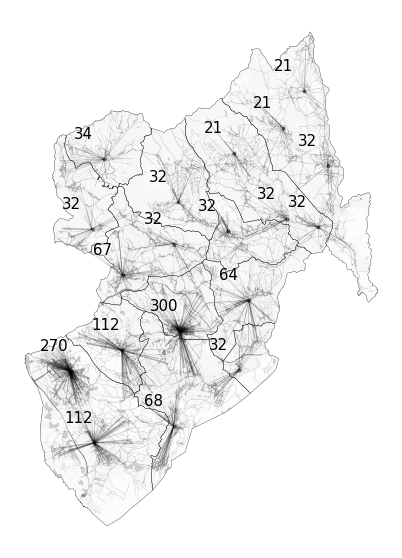

In [18]:
alunos_alocados = {}
for (i,j,k) in d:
    if x[(i,j,k)].X > 0.001:
        alunos_alocados [i,j] = i, j, d[i,j,k], d_dist[i,j]
        
df_alunos_alocados = pd.DataFrame.from_dict(alunos_alocados, orient='index', columns=[ 'SubSection', 'School', 'alunos_aloc', 'distancia',])
# df_alunos_alocados.sum(axis=0)
df_alunos_alocados['prod_dist_alun'] = df_alunos_alocados.alunos_aloc*df_alunos_alocados.distancia
#Cria as linhas dos alunos alocadas  para serem plotadas 
d_linhas={}
d_lic={}

for procura, escolas in df_alunos_alocados.index: 
    d_linhas[procura, escolas] = float(df_alunos_alocados.loc[[(procura,escolas)],'alunos_aloc'])
    d_lic[procura, escolas] = LineString([gdf_BGRI_2011_Ourem.loc[procura,:].centroid, gdf_BGRI_2011_Ourem.loc[escolas,:].centroid])

gdg_linhas = gpd.GeoDataFrame(index= d_lic.keys())
gdg_linhas.geometry=list(d_lic.values())
gdg_linhas['linhas'] = list(d_linhas.values())
colors_cos = {'Territórios artificializados': (0, 0, 0), 'Agricultura': (0.75, 0.75, 0.75), 
              'Pastagens': (0.9, 0.9, 0.9), 'Sistemas agro-florestais': (0.85, 0.85, 0.85),
              'Florestas': (0.85, 0.85, 0.85),  'Matos': (0.95, 0.95, 0.95),
              'Espaços descobertos ou com vegetação esparsa': (1, 1, 1),
              'Zonas húmidas': (1, 1, 1), 'Corpos de água': (0.3, 0.3, 0.3)}
colors_cos_hexa = rgb_to_hex(colors_cos)

fig, ax = plt.subplots(figsize=(10, 10))

# Plota os limites das freguesias 
gdf_freguesia_CAOP2018.plot(ax=ax,facecolor='None', edgecolor='black', linewidth=0.3, zorder=10)

#Plota ocupação e uso de solo por categoria, em função do esquema de cores definido em colors_cos_hexa
for categoria, data in gdf_COS_2015.groupby('Megaclasse'):
    # Define the color for each group using the dictionary
    color = colors_cos_hexa[categoria]
    # Plot each group using the color defined above
    data.plot(color=color, ax=ax, alpha=0.2)
    
#Plota a rede de estradas, em função da linewidths e alphas definido em dict_temp 
for ctype, data in gdf_open_street2019.groupby('fclass'):
    alpha = dict_temp[ctype][0]
    linewidth = dict_temp[ctype][0]
    data.plot(color = 'black', ax=ax, alpha=0.4, linewidth=linewidth)

# #Plota as escolas localizadas 
# for i,k in y:
#     offset = {'x':-30, 'y':20}
#     offset = {'x':15, 'y':20} if i=='14211500508' else offset
#     if (y[i,k].X > 0.000000001):
#         ax.plot(gdf_BGRI_2011_Ourem.loc[i,:].centroid.x, gdf_BGRI_2011_Ourem.loc[i,:].centroid.y, 
#                 marker='o',color ='black', alpha=0.4, markersize=3)
#         ax.annotate(str(int(round(d_escolas_localizadas[i][1]))), xy=(gdf_BGRI_2011_Ourem.loc[i].centroid.x, gdf_BGRI_2011_Ourem.loc[i].centroid.y),
#                 size=15, xytext=(offset['x'], offset['y']), textcoords='offset points', bbox=dict(boxstyle="round", alpha=0.4, color='white'))

#Plota as escolas localizadas 
escolas_localizadas = df_alunos_alocados.groupby('School').sum().alunos_aloc
for i in escolas_localizadas.index:
    offset = {'x':-30, 'y':20}
#     offset = {'x':15, 'y':20} if i=='14211500508' else offset
    ax.plot(gdf_BGRI_2011_Ourem.loc[i,:].centroid.x, gdf_BGRI_2011_Ourem.loc[i,:].centroid.y, 
                marker='o',color ='black', alpha=0.4, markersize=3)
    ax.annotate(str(int(round(escolas_localizadas[i]))), xy=(gdf_BGRI_2011_Ourem.loc[i].centroid.x, 
                gdf_BGRI_2011_Ourem.loc[i].centroid.y), size=15, xytext=(offset['x'], offset['y']), 
                textcoords='offset points', bbox=dict(boxstyle="round", alpha=0.4, color='white'))
        
#Plota a rede as linhas de alocação das subsecções às escolas
gdg_linhas.plot(ax=ax, linewidth=gdg_linhas['linhas']/3, color='black', alpha=0.3)

ax.set_axis_off()
# ax.legend(loc=2, prop={'size': 14}, bbox_to_anchor=(0.7, 0.3))

# plt.savefig('Ourém_localizações_eficiencia_pop_2020.tif', dpi=600, bbox_inches='tight')
plt.show()

In [19]:
weighted_stats_eficiencia = DescrStatsW(df_alunos_alocados.distancia, df_alunos_alocados.alunos_aloc)
weighted_stats_eficiencia.mean

1935.1981448742185

In [20]:
d_outcomes = {'Loc_capacitada': [df_alunos_alocados.distancia.max(),
                        weighted_stats_eficiencia.mean,
                        weighted_stats_eficiencia.std, 
                        weighted_stats_eficiencia.std/weighted_stats_eficiencia.mean]
             }

df_outcomes = pd.DataFrame(d_outcomes)
df_outcomes.index = 'Maximum value', 'Mean', 'Standard deviation', 'Coefficient of variation'
df_outcomes = round(df_outcomes, 2)

df_outcomes

,Loc_capacitada
Maximum value,4198.35
Mean,1935.20
Standard deviation,1196.19
Coefficient of variation,0.62


In [21]:
def Adicionar_percenatens (df_gini):
    df_gini = df_gini.sort_values(by= 'distancia')
    df_gini['percent_dist'] =  df_gini.prod_dist_alun / df_gini.prod_dist_alun.sum()
    df_gini['percent_alunos'] =  df_gini.alunos_aloc / df_gini.alunos_aloc.sum()
    df_gini['Dist_cumsum'] = df_gini.prod_dist_alun.cumsum()/df_gini.prod_dist_alun.sum()
    df_gini['Alunos_cumsum'] = df_gini.alunos_aloc.cumsum()/df_gini.alunos_aloc.sum()
    return(df_gini)

In [22]:
df_alunos_alocados_c_perc = Adicionar_percenatens(df_alunos_alocados)
df_alunos_alocados_c_perc[df_alunos_alocados_c_perc.distancia<=1500].sum()

SubSection        1421080042114211501111142112004121421040021214...
School            1421080042114211501111142112004131421040021214...
alunos_aloc                                                 534.546
distancia                                                    224192
prod_dist_alun                                               377310
percent_dist                                               0.144958
percent_alunos                                             0.397425
Dist_cumsum                                                 18.0985
Alunos_cumsum                                               64.2867
dtype: object

In [26]:
# df_alunos_alocados_c_perc.to_csv('alunos_alocados_RESTRICAO_MAX_2020.csv')
# df_outcomes.to_csv('alunos_alocados_equidade_2020.csv')

In [ ]:
# for j, k in y:
# #     print([j, k][1]*y[j, k])
# #     print([j,k][1]* y[j, k].X)
#     print(quicksum([x[i,j,k].x for i in localizacoes])-[j,k][1]*y[j, k].X)